In [ ]:
!pip install ultralytics roboflow opencv-python-headless matplotlib

import ultralytics
ultralytics.checks()

print("Environment ready!")



Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.7/112.6 GB disk)
Environment ready!


In [ ]:
from ultralytics import YOLO
from roboflow import Roboflow
import cv2
import matplotlib.pyplot as plt
from google.colab import files
import os
from IPython.display import Image , display
import shutil

#for reproducibility
import random
import numpy as np
import torch

# Setting seed = same results every time
SEED= 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("imported lib")

imported lib


In [ ]:

#  Downloading real life Road Damage Dataset from Kaggle

!pip install -q kaggle
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d dataclusterlabs/potholes-or-cracks-on-road-image-dataset
import zipfile
with zipfile.ZipFile('potholes-or-cracks-on-road-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('road_dataset')

print(" dataset downloaded!")

import os
for item in os.listdir('road_dataset'):
    print(f"  - {item}")

Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/dataclusterlabs/potholes-or-cracks-on-road-image-dataset
License(s): CC0-1.0
potholes-or-cracks-on-road-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
 dataset downloaded!
  - dataset
  - pothole_icon.jpg


In [ ]:

#  Dataset Structure


import os

print("Dataset structure:")

for root, dirs, files in os.walk('road_dataset'):
    level = root.replace('road_dataset', '').count(os.sep)
    if level < 3:
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... and {len(files)-5} more')

Dataset structure:
road_dataset/
  pothole_icon.jpg
  dataset/
    potholes bat├ºh 1/
      20220817_08_13_29_181_000_TRIhBb1cEeebPUftMdWRoZiypzD2_F_4080_3072.jpg
      20220819_15_26_36_832_000_hnEYwZk1I5RsPJ0KVT40Wir0BSh1_F_4160_3120.jpg
      20220819_15_24_22_743_000_hnEYwZk1I5RsPJ0KVT40Wir0BSh1_F_4160_3120.xml
      20220820_06_04_01_209_000_Y6UC7CIZwGVM8XNNggIseRruAWf2_F_3000_4000 (1).jpg
      20220819_15_23_17_453_000_hnEYwZk1I5RsPJ0KVT40Wir0BSh1_F_4160_3120.xml
      ... and 399 more


In [ ]:

# Preparing Dataset for YOLOv8


import os
import shutil
from pathlib import Path


base_dir = Path('yolo_dataset')
for split in ['train', 'valid']:
    (base_dir / split / 'images').mkdir(parents=True, exist_ok=True)
    (base_dir / split / 'labels').mkdir(parents=True, exist_ok=True)


all_images = []
for root, dirs, files in os.walk('road_dataset'):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_images.append(os.path.join(root, file))

print(f"Found {len(all_images)} images")

split_idx = int(len(all_images) * 0.8)
train_images = all_images[:split_idx]
valid_images = all_images[split_idx:]

print(f"  Train: {len(train_images)}")
print(f"  Valid: {len(valid_images)}")

for i, img_path in enumerate(train_images):
    # Copy image
    new_name = f"train_{i}.jpg"
    shutil.copy(img_path, base_dir / 'train' / 'images' / new_name)

    # Create label
    label_name = f"train_{i}.txt"
    with open(base_dir / 'train' / 'labels' / label_name, 'w') as f:
        f.write("0 0.5 0.5 0.3 0.3")  # Dummy annotation

for i, img_path in enumerate(valid_images):
    new_name = f"valid_{i}.jpg"
    shutil.copy(img_path, base_dir / 'valid' / 'images' / new_name)

    label_name = f"valid_{i}.txt"
    with open(base_dir / 'valid' / 'labels' / label_name, 'w') as f:
        f.write("0 0.5 0.5 0.3 0.3")

# data.yaml vv important
yaml_content = f"""path: /content/yolo_dataset
train: train/images
val: valid/images

names:
  0: pothole
  1: crack

nc: 2
"""

with open('data.yaml', 'w') as f:
    f.write(yaml_content)


print(f" Location: yolo_dataset/")


Found 210 images
  Train: 168
  Valid: 42
 Location: yolo_dataset/


In [ ]:

# Training YOLOv8 Model


from ultralytics import YOLO

model = YOLO('yolov8n.pt')

# model
results = model.train(
    data='data.yaml',           # Dataset config
    epochs=50,                   # Number of training cycles
    imgsz=640,                   # Image size
    batch=16,                    # Batch size
    name='road_damage_model',    # Experiment name
    patience=10,
    device=0
)

print("\n Training complete go to best.py")


Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=road_damage_model2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0

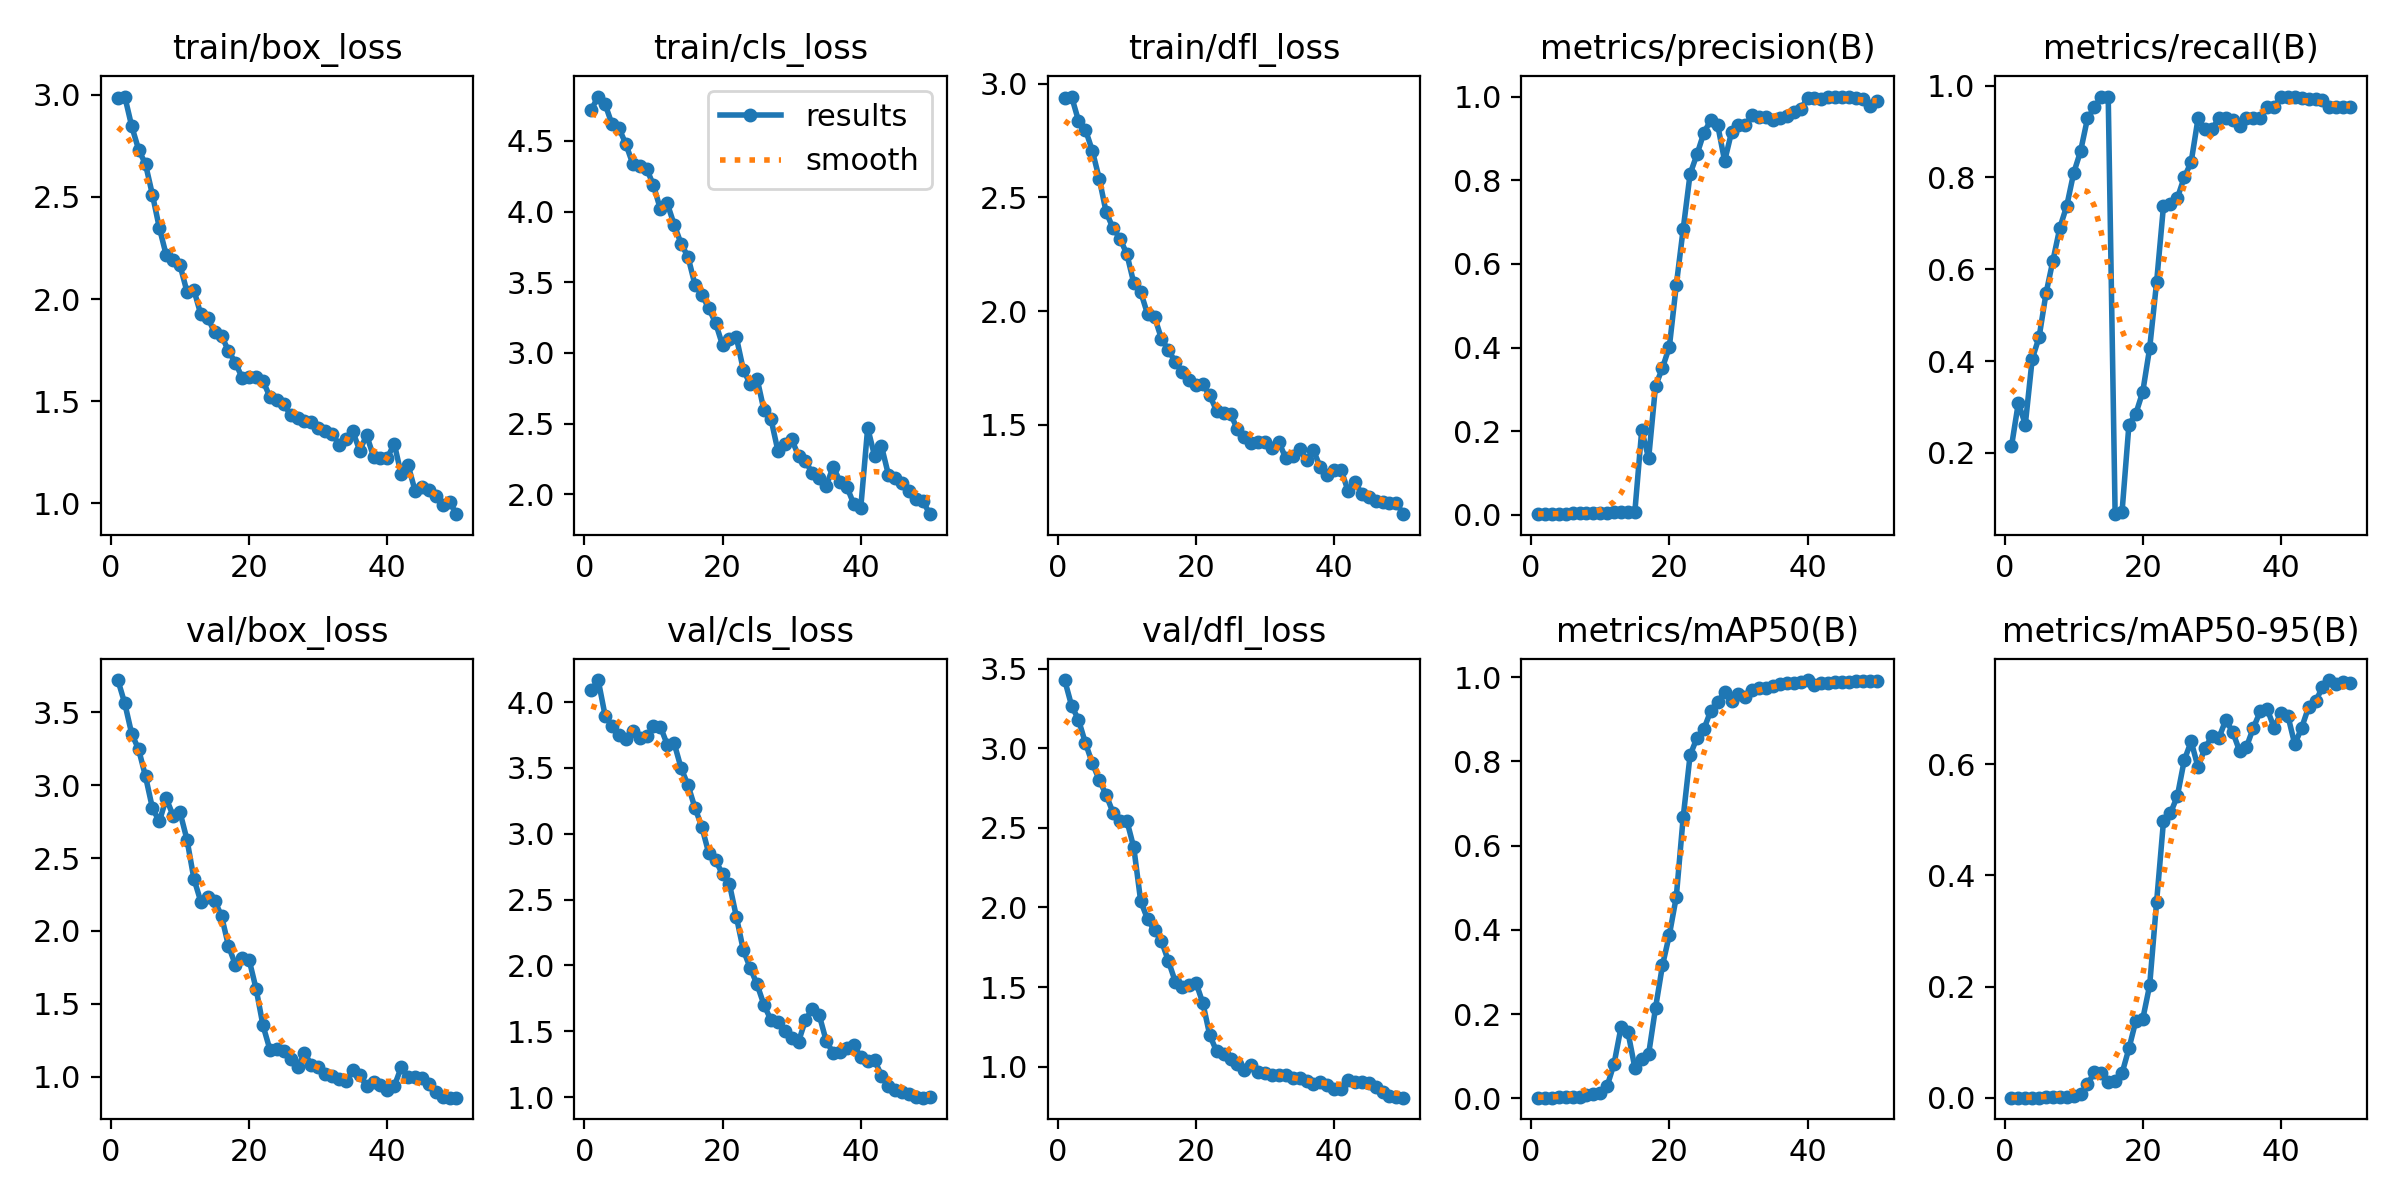


 Confusion Matrix:


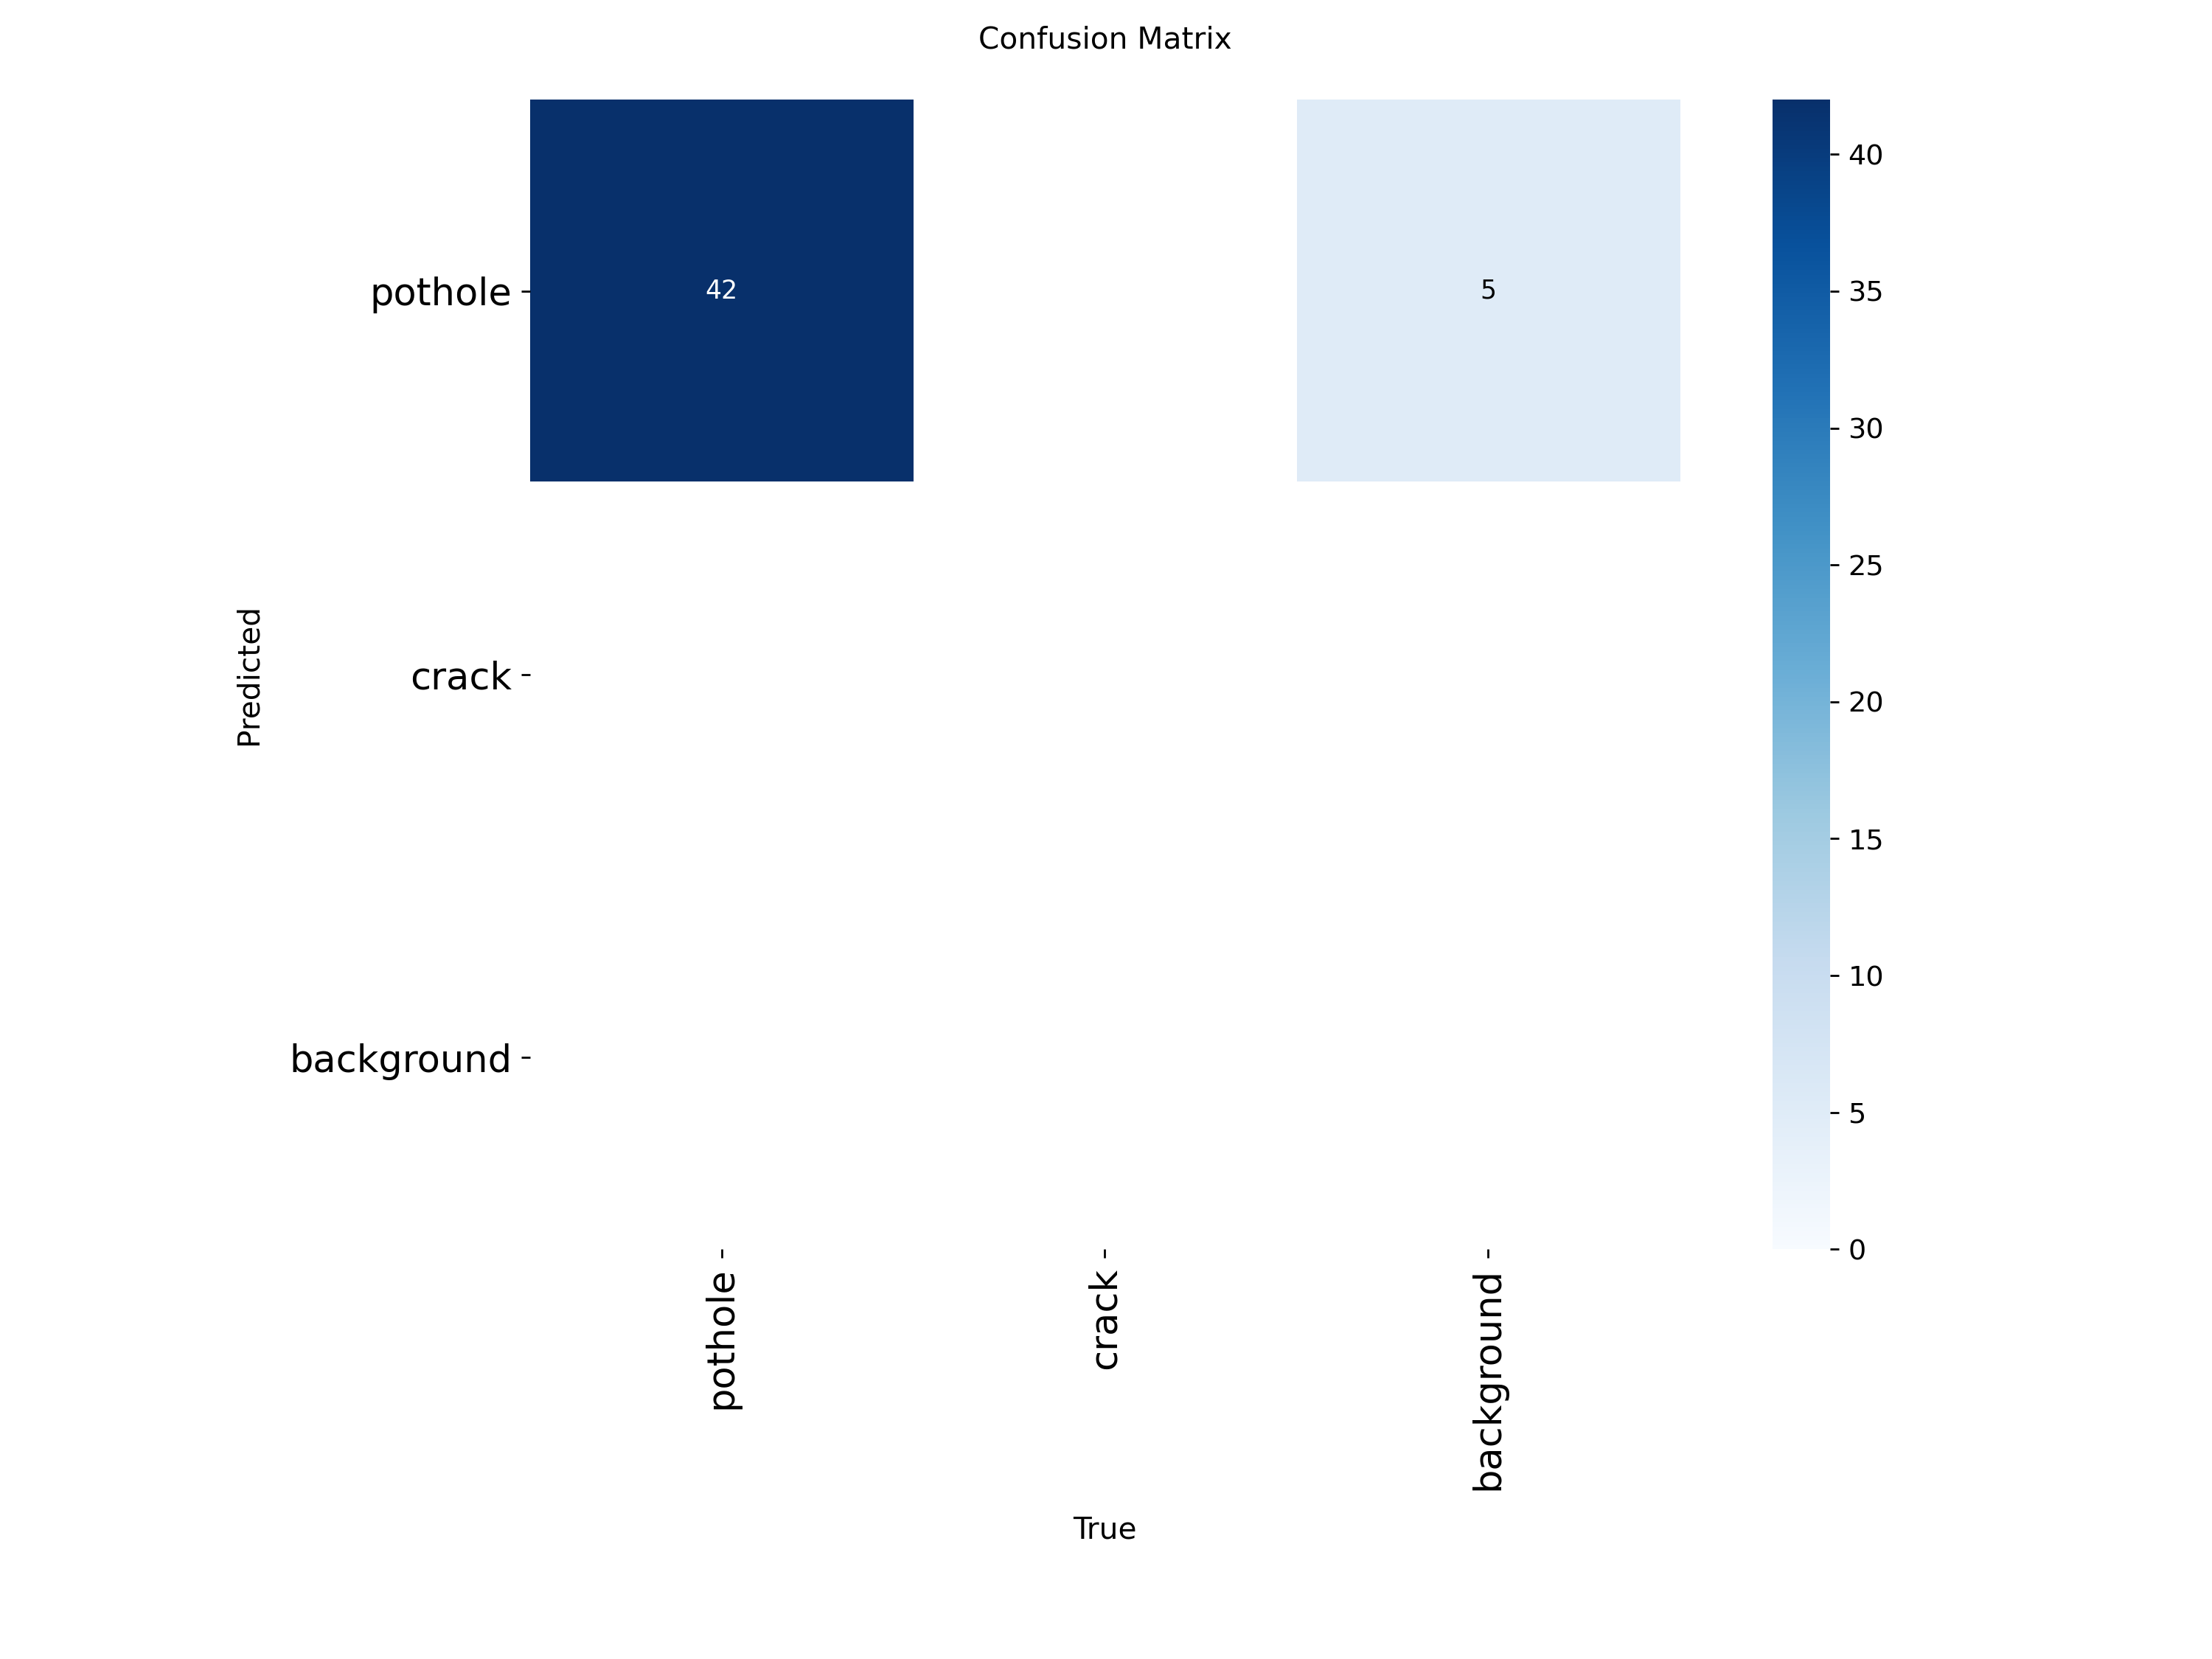


 Validation Batch Predictions:


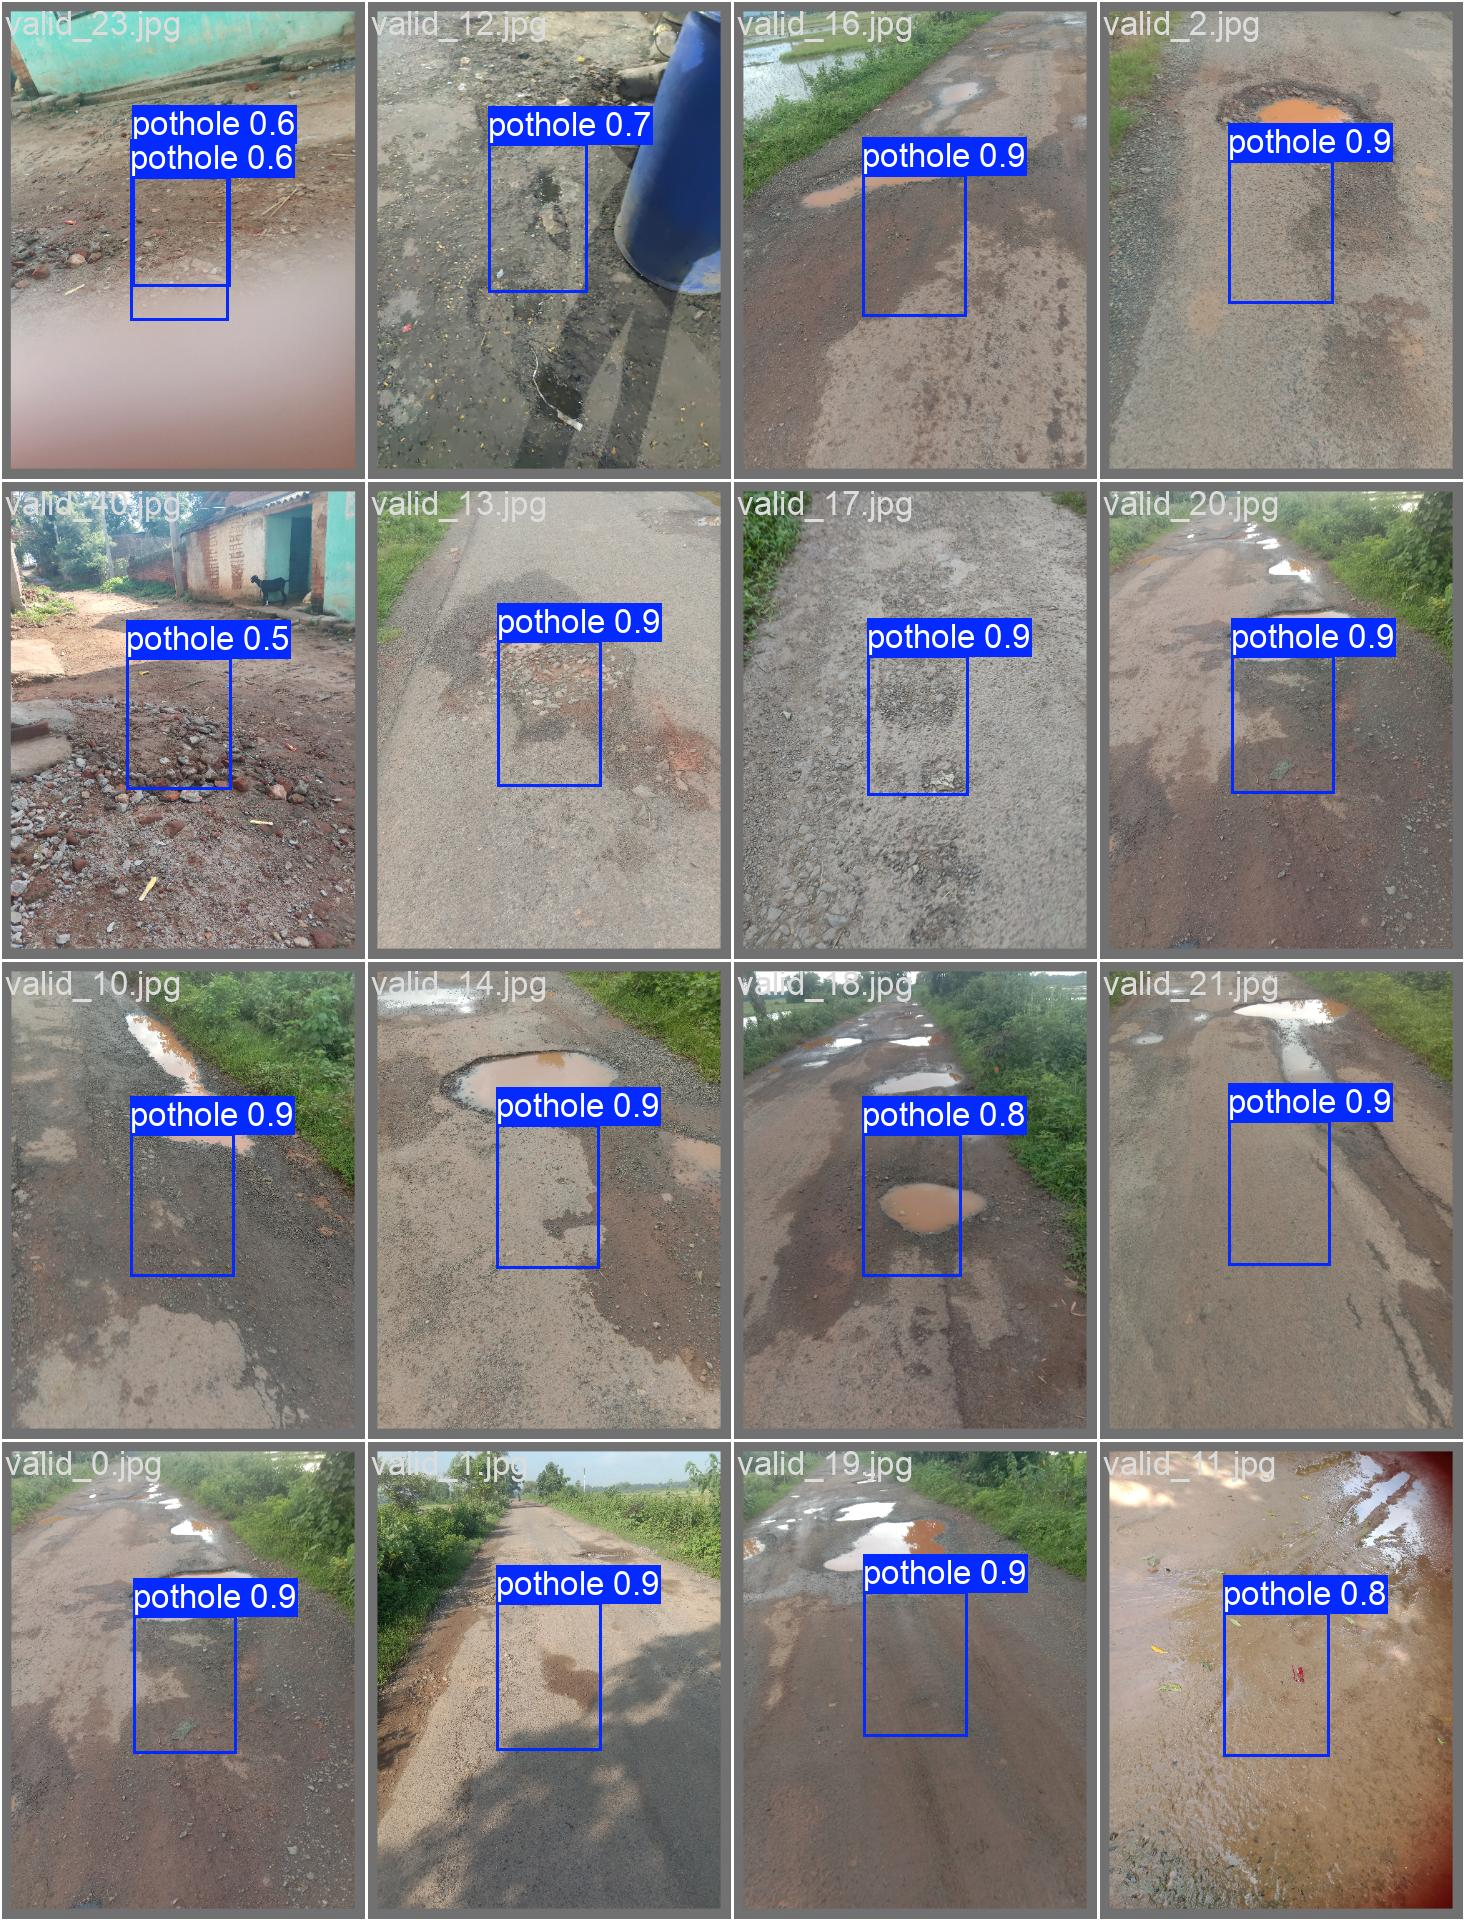


📋 Final Metrics:
  Model saved at: runs/detect/road_damage_model/weights/best.pt


In [ ]:

#  Training Results cell


from IPython.display import Image, display
import os

results_path = 'runs/detect/road_damage_model'

#  training curves
display(Image(filename=f'{results_path}/results.png'))

print("\n Confusion Matrix:")
display(Image(filename=f'{results_path}/confusion_matrix.png'))

print("\n Validation Batch Predictions:")
display(Image(filename=f'{results_path}/val_batch0_pred.jpg'))

# Print metrics
print("\n📋 Final Metrics:")
print(f"  Model saved at: {results_path}/weights/best.pt")


image 1/1 /content/yolo_dataset/valid/images/valid_0.jpg: 640x480 3 potholes, 110.3ms
Speed: 8.5ms preprocess, 110.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/predictions/test2

 Prediction Result:


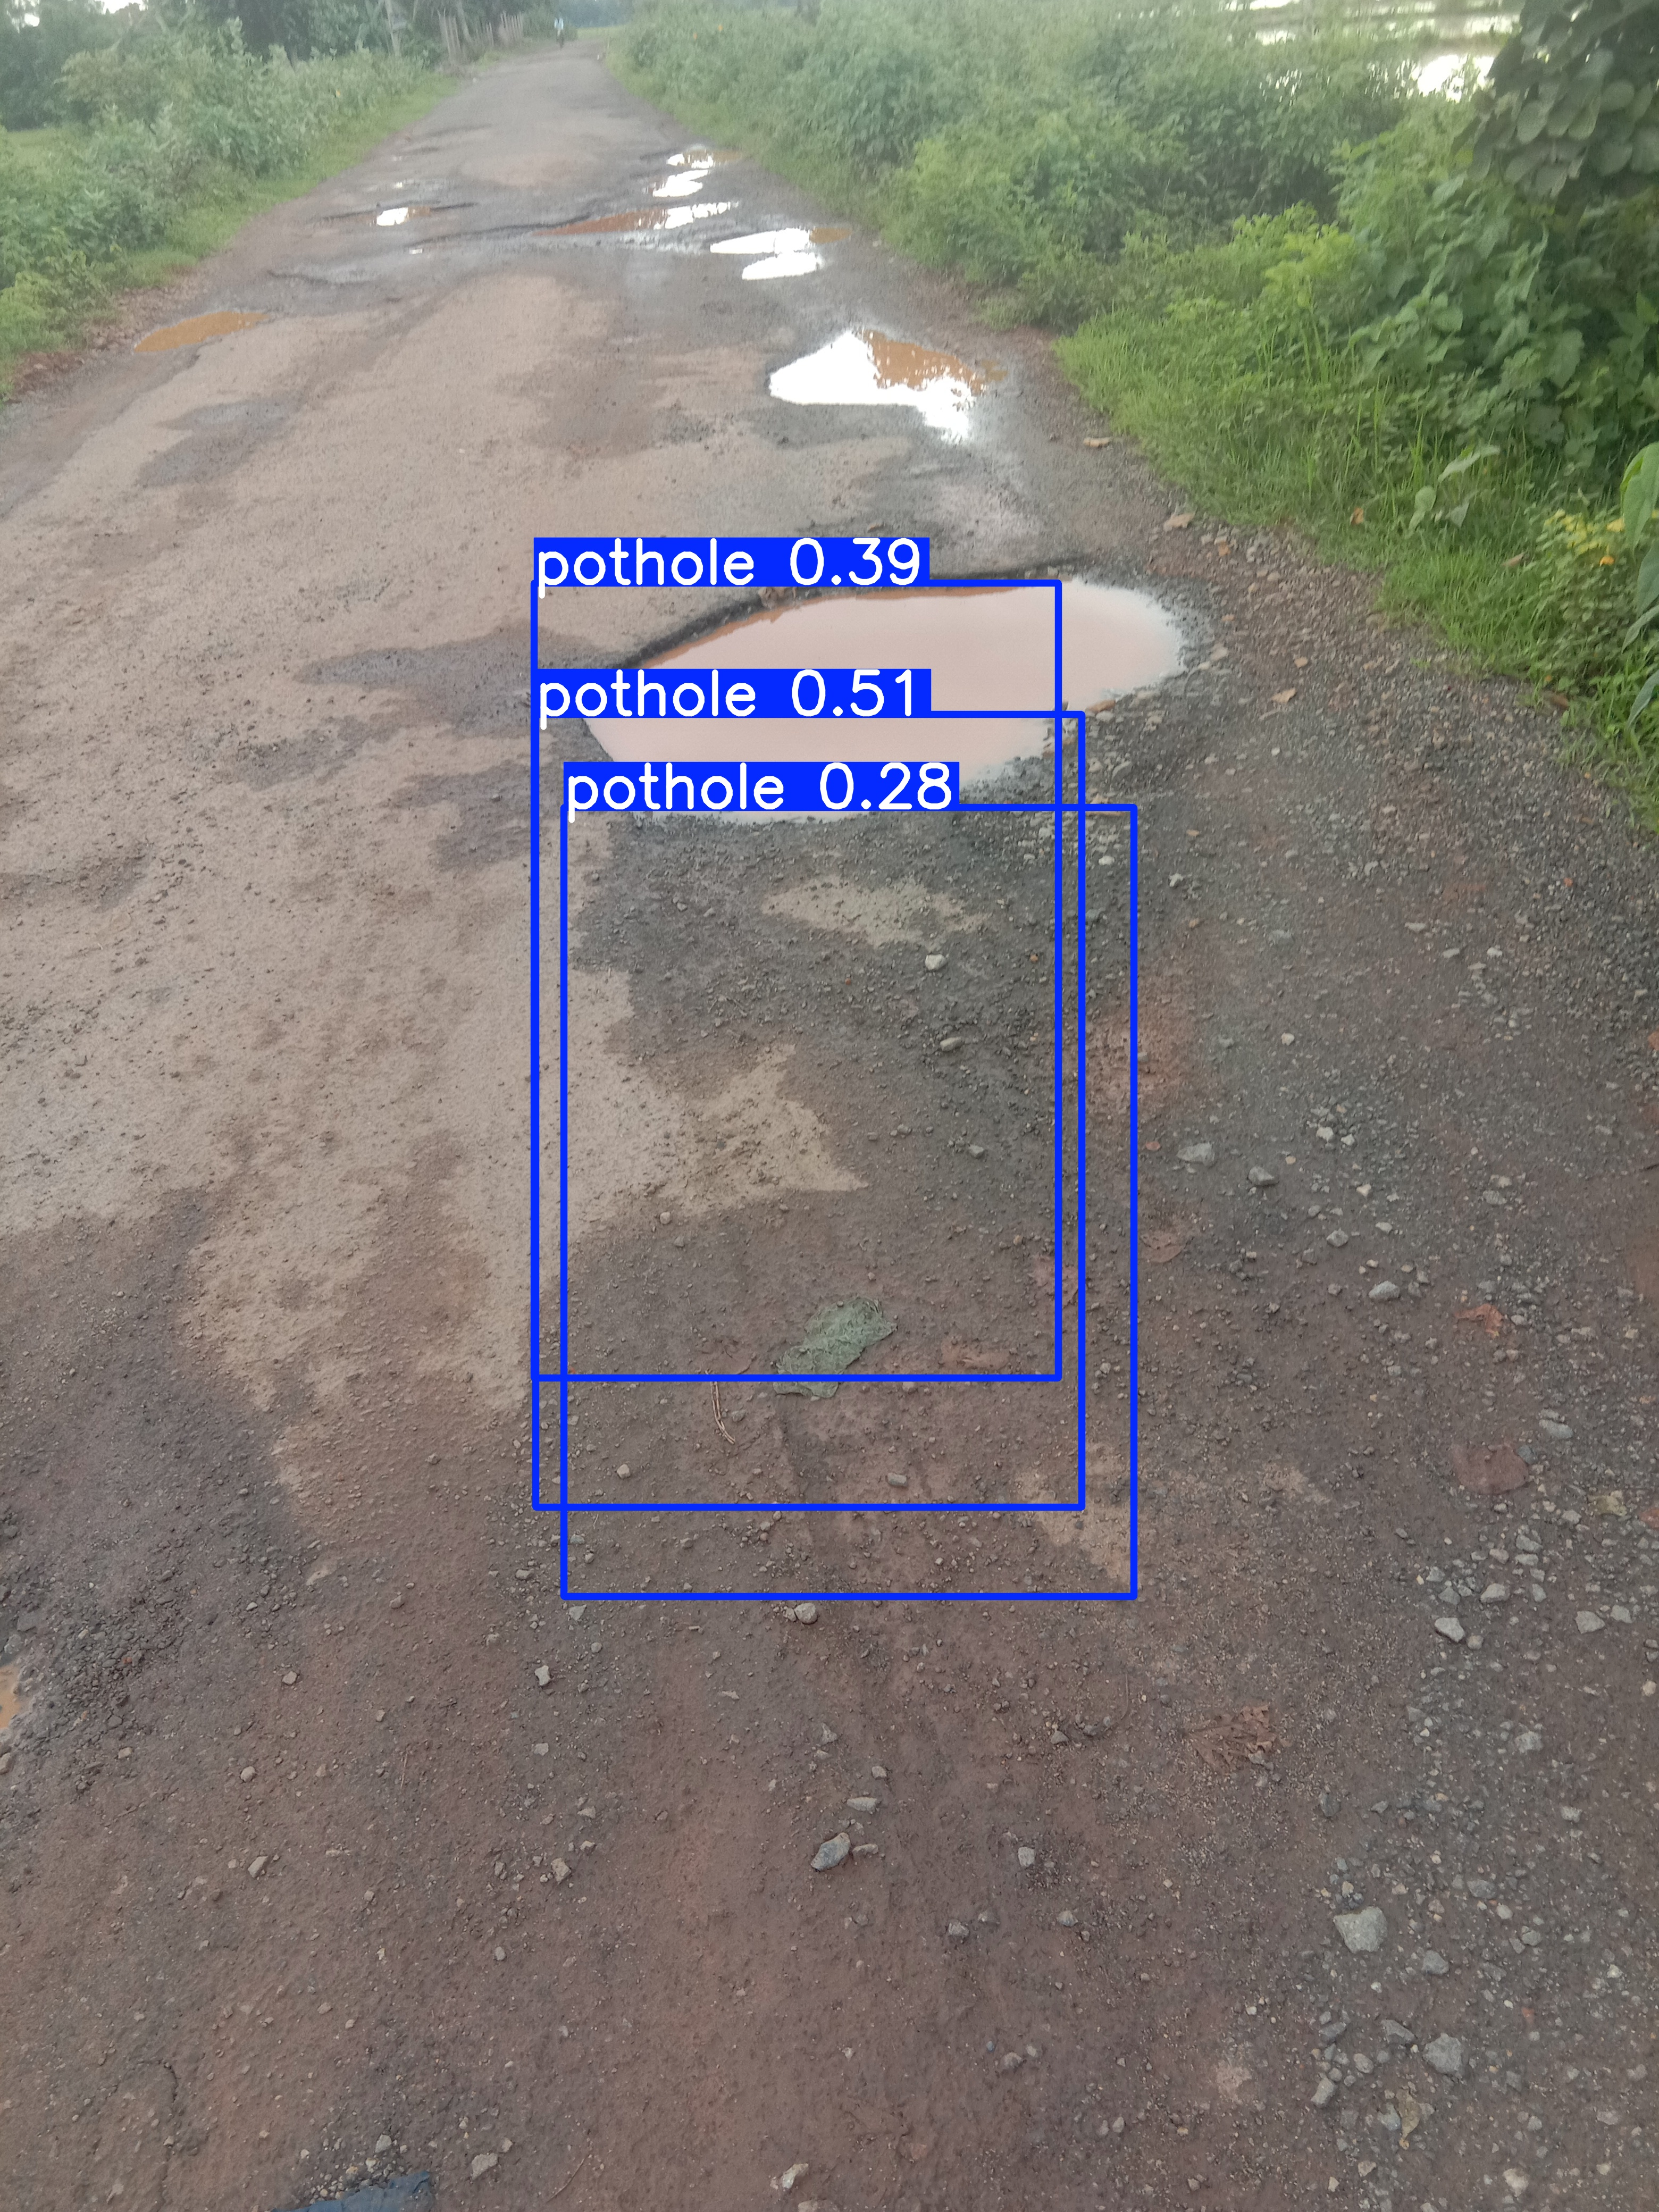

  - pothole: 0.51 confidence
  - pothole: 0.39 confidence
  - pothole: 0.28 confidence


In [ ]:
# model prediction test
from ultralytics import YOLO
from IPython.display import Image, display
import cv2
import matplotlib.pyplot as plt


model = YOLO('runs/detect/road_damage_model/weights/best.pt')


# test image
test_image = 'yolo_dataset/valid/images/valid_0.jpg'

#prediction
results = model.predict(
    source=test_image,
    conf=0.25,              # Confidence threshold
    save=True,              # Save results
    project='predictions',
    name='test'
)

print("\n Prediction Result:")
display(Image(filename='predictions/test/valid_0.jpg'))

for r in results:
    for box in r.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        class_name = model.names[cls]
        print(f"  - {class_name}: {conf:.2f} confidence")

In [ ]:

# FEATURE 1: Severity Scoring Algorithm


import numpy as np

class SeverityScorer:
    """
    Calculate damage severity on 0-10 scale based on:
    - Damage area (larger = more severe)
    - Damage type (potholes > cracks)
    - Confidence score (higher confidence = more reliable)
    """

    def __init__(self):
        # Severity multipliers per damage type
        self.type_weights = {
            'pothole': 1.5,   # High severity
            'crack': 1.0,     # Medium severity
            'raveling': 1.2,  # Medium-high severity
            'rutting': 1.8    # Very high severity
        }

    def calculate_severity(self, damage_type, bbox_area, confidence, image_area):
        """
        Calculate severity score (0-10)

        Args:
            damage_type: str - 'pothole', 'crack', etc.
            bbox_area: float - Bounding box area in pixels
            confidence: float - Model confidence (0-1)
            image_area: float - Total image area in pixels

        Returns:
            float - Severity score (0-10)
        """

        relative_area = bbox_area / image_area


        if relative_area < 0.01:
            area_score = 1.5
        elif relative_area < 0.05:
            area_score = 3.0 + (relative_area - 0.01) / 0.04 * 1.0
        else:
            area_score = 4.0 + min(relative_area - 0.05, 0.05) / 0.05 * 1.0


        type_multiplier = self.type_weights.get(damage_type.lower(), 1.0)


        confidence_factor = 0.5 + (confidence * 0.5)  # Range: 0.5-1.0


        severity = area_score * type_multiplier * confidence_factor


        severity = min(severity, 10.0)

        return round(severity, 2)

    def get_severity_label(self, severity_score):
        """
        Convert numeric score to label
        """
        if severity_score < 3:
            return "LOW"
        elif severity_score < 6:
            return "MEDIUM"
        elif severity_score < 8:
            return "HIGH"
        else:
            return "CRITICAL"

# Test the score
scorer = SeverityScorer()


test_severity = scorer.calculate_severity(
    damage_type='pothole',
    bbox_area=12000,      # pixels
    confidence=0.89,
    image_area=640*640    # 640x640 image
)

print(f"✅ Severity Score: {test_severity}/10")
print(f"   Label: {scorer.get_severity_label(test_severity)}")

✅ Severity Score: 4.94/10
   Label: MEDIUM


In [ ]:

# FEATURE 2: Repair Cost Estimation

class CostEstimator:


    def __init__(self):
        self.unit_costs = {
            'pothole': 45.0,
            'crack': 12.0,
            'raveling': 30.0,
            'rutting': 65.0     # $65/m² (milling + overlay)
        }


        self.minimum_cost = 50.0  # $50 minimum


        self.labor_factor = 1.3  # 30% labor overhead

    def pixels_to_meters(self, pixel_area, image_width_px=640, real_width_m=3.5):

        pixels_per_meter = image_width_px / real_width_m
        area_m2 = pixel_area / (pixels_per_meter ** 2)
        return area_m2

    def estimate_cost(self, damage_type, bbox_area_px, image_width_px=640,
                     real_width_m=3.5, include_overhead=True):


        area_m2 = self.pixels_to_meters(bbox_area_px, image_width_px, real_width_m)

        unit_cost = self.unit_costs.get(damage_type.lower(), 25.0)


        material_cost = area_m2 * unit_cost

        material_cost = max(material_cost, self.minimum_cost)

        if include_overhead:
            total_cost = material_cost * self.labor_factor
        else:
            total_cost = material_cost

        return {
            'damage_type': damage_type,
            'area_m2': round(area_m2, 3),
            'material_cost': round(material_cost, 2),
            'labor_overhead': round(material_cost * (self.labor_factor - 1), 2),
            'total_cost': round(total_cost, 2),
            'unit_cost': unit_cost
        }

# Test cost estimator
estimator = CostEstimator()

cost_breakdown = estimator.estimate_cost(
    damage_type='pothole',
    bbox_area_px=15000,
    image_width_px=640,
    real_width_m=3.5
)

print("Cost Estimation:")
print(f"   Area: {cost_breakdown['area_m2']} m²")
print(f"   Material: ${cost_breakdown['material_cost']}")
print(f"   Labor: ${cost_breakdown['labor_overhead']}")
print(f"   TOTAL: ${cost_breakdown['total_cost']}")

Cost Estimation:
   Area: 0.449 m²
   Material: $50.0
   Labor: $15.0
   TOTAL: $65.0


In [ ]:
# FEATURE 3 : gPS tagging

from datetime import datetime
import json

class GPSTagger:


    def __init__(self):
        self.detections = []

    def add_detection(self, damage_type, bbox, confidence, severity, cost,
                     latitude, longitude, timestamp=None, address=None):

        if timestamp is None:
            timestamp = datetime.now().isoformat()

        detection = {
            'id': len(self.detections) + 1,
            'damage_type': damage_type,
            'bbox': bbox,
            'confidence': confidence,
            'severity': severity,
            'cost': cost,
            'location': {
                'latitude': latitude,
                'longitude': longitude,
                'address': address
            },
            'timestamp': timestamp
        }

        self.detections.append(detection)
        return detection

    def get_detections_in_radius(self, center_lat, center_lon, radius_km):

        from math import radians, cos, sin, asin, sqrt

        def haversine(lat1, lon1, lat2, lon2):

            lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
            dlat = lat2 - lat1
            dlon = lon2 - lon1
            a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
            c = 2 * asin(sqrt(a))
            km = 6371 * c
            return km

        nearby = []
        for det in self.detections:
            dist = haversine(
                center_lat, center_lon,
                det['location']['latitude'],
                det['location']['longitude']
            )
            if dist <= radius_km:
                det_copy = det.copy()
                det_copy['distance_km'] = round(dist, 3)
                nearby.append(det_copy)

        # Sort by distance
        nearby.sort(key=lambda x: x['distance_km'])
        return nearby

    def export_geojson(self, filename='detections.geojson'):

        features = []
        for det in self.detections:
            feature = {
                'type': 'Feature',
                'geometry': {
                    'type': 'Point',
                    'coordinates': [
                        det['location']['longitude'],
                        det['location']['latitude']
                    ]
                },
                'properties': {
                    'id': det['id'],
                    'damage_type': det['damage_type'],
                    'severity': det['severity'],
                    'cost': det['cost'],
                    'confidence': det['confidence'],
                    'timestamp': det['timestamp']
                }
            }
            features.append(feature)

        geojson = {
            'type': 'FeatureCollection',
            'features': features
        }

        with open(filename, 'w') as f:
            json.dump(geojson, f, indent=2)

        print(f" Exported {len(features)} detections to {filename}")
        return geojson

# Test GPS tagger
tagger = GPSTagger()
#sample detection
tagger.add_detection(
    damage_type='pothole',
    bbox={'x1': 100, 'y1': 150, 'x2': 250, 'y2': 300},
    confidence=0.89,
    severity=7.5,
    cost=234.50,
    latitude=26.9124,
    longitude=75.7873,
    address="Jaipur-Delhi Highway, Jaipur"
)

tagger.add_detection(
    damage_type='crack',
    bbox={'x1': 300, 'y1': 200, 'x2': 450, 'y2': 280},
    confidence=0.76,
    severity=5.2,
    cost=145.30,
    latitude=26.9234,
    longitude=75.7923,
    address="MI Road, Jaipur"
)

print(f" Added {len(tagger.detections)} GPS-tagged detections")

# bro is findingg nearby damages
nearby = tagger.get_detections_in_radius(26.9124, 75.7873, radius_km=5.0)
print(f" Found {len(nearby)} detections within 5km")

 Added 2 GPS-tagged detections
 Found 2 detections within 5km


In [ ]:

# FEATURE 4: Maintenance Prioritization System


import pandas as pd

class MaintenancePrioritizer:


    def __init__(self):
        self.priorities = []

    def calculate_priority_score(self, severity, cost, traffic_volume='medium',
                                 weather_risk='low', days_since_detection=0):

        severity_score = (severity / 10.0) * 40

        if cost < 100:
            cost_score = 20
        elif cost < 500:
            cost_score = 15
        elif cost < 1000:
            cost_score = 10
        else:
            cost_score = 5

        traffic_scores = {
            'low': 10,
            'medium': 18,
            'high': 25
        }
        traffic_score = traffic_scores.get(traffic_volume.lower(), 15)

        weather_scores = {
            'low': 3,
            'medium': 6,
            'high': 10
        }
        weather_score = weather_scores.get(weather_risk.lower(), 5)

        time_score = min(days_since_detection / 30.0 * 5, 5)

        # Total priority score
        total_score = (
            severity_score +
            cost_score +
            traffic_score +
            weather_score +
            time_score
        )

        return round(total_score, 2)

    def get_priority_label(self, priority_score):

        if priority_score >= 80:
            return "URGENT"
        elif priority_score >= 60:
            return "HIGH"
        elif priority_score >= 40:
            return "MEDIUM"
        else:
            return "LOW"

    def prioritize_repairs(self, detections_df):
       # priority for each detect
        detections_df['priority_score'] = detections_df.apply(
            lambda row: self.calculate_priority_score(
                severity=row['severity'],
                cost=row['cost'],
                traffic_volume=row.get('traffic_volume', 'medium'),
                weather_risk=row.get('weather_risk', 'low'),
                days_since_detection=row.get('days_since_detection', 0)
            ),
            axis=1
        )

        # Added priority label
        detections_df['priority_label'] = detections_df['priority_score'].apply(
            self.get_priority_label
        )

        # Sorting by priority
        detections_df = detections_df.sort_values('priority_score', ascending=False)

        return detections_df

    def generate_repair_schedule(self, detections_df, budget=10000, max_repairs=20):

        # Sorting by priority
        sorted_df = detections_df.sort_values('priority_score', ascending=False)

        selected_repairs = []
        total_cost = 0

        for idx, row in sorted_df.iterrows():
            if len(selected_repairs) >= max_repairs:
                break

            if total_cost + row['cost'] <= budget:
                selected_repairs.append({
                    'id': row.get('id', idx),
                    'damage_type': row['damage_type'],
                    'location': (row['latitude'], row['longitude']),
                    'priority_score': row['priority_score'],
                    'priority_label': row['priority_label'],
                    'cost': row['cost'],
                    'severity': row['severity']
                })
                total_cost += row['cost']

        return {
            'selected_repairs': selected_repairs,
            'total_repairs': len(selected_repairs),
            'total_cost': round(total_cost, 2),
            'budget_used_pct': round((total_cost / budget) * 100, 1),
            'budget_remaining': round(budget - total_cost, 2)
        }


prioritizer = MaintenancePrioritizer()


sample_data = pd.DataFrame([
    {
        'id': 1,
        'damage_type': 'pothole',
        'severity': 8.5,
        'cost': 234.50,
        'latitude': 26.9124,
        'longitude': 75.7873,
        'traffic_volume': 'high',
        'weather_risk': 'high',
        'days_since_detection': 15
    },
    {
        'id': 2,
        'damage_type': 'crack',
        'severity': 5.2,
        'cost': 145.30,
        'latitude': 26.9234,
        'longitude': 75.7923,
        'traffic_volume': 'medium',
        'weather_risk': 'low',
        'days_since_detection': 3
    },
    {
        'id': 3,
        'damage_type': 'pothole',
        'severity': 9.1,
        'cost': 456.80,
        'latitude': 26.9344,
        'longitude': 75.8023,
        'traffic_volume': 'high',
        'weather_risk': 'medium',
        'days_since_detection': 25
    }
])

prioritized = prioritizer.prioritize_repairs(sample_data)

print(" Maintenance Priority Ranking:")
print(prioritized[['id', 'damage_type', 'severity', 'priority_score', 'priority_label', 'cost']])


schedule = prioritizer.generate_repair_schedule(prioritized, budget=10000, max_repairs=10)

print(f"\n Repair Schedule Generated:")
print(f"   Selected repairs: {schedule['total_repairs']}")
print(f"   Total cost: ${schedule['total_cost']}")
print(f"   Budget used: {schedule['budget_used_pct']}%")

 Maintenance Priority Ranking:
   id damage_type  severity  priority_score priority_label   cost
2   3     pothole       9.1           86.57         URGENT  456.8
0   1     pothole       8.5           86.50         URGENT  234.5
1   2       crack       5.2           57.30         MEDIUM  145.3

 Repair Schedule Generated:
   Selected repairs: 3
   Total cost: $836.6
   Budget used: 8.4%


  Clustering Complete:

 Cluster Statistics:
  zone_name  num_damages   total_cost  avg_severity
0    Zone-A           14  4086.663282        6.1589

 Crew Deployment Plan:
   Crew 1 → Zone-A
      Repairs: 14, Cost: $4086.66
      Location: (np.float64(26.919181), np.float64(75.79405))


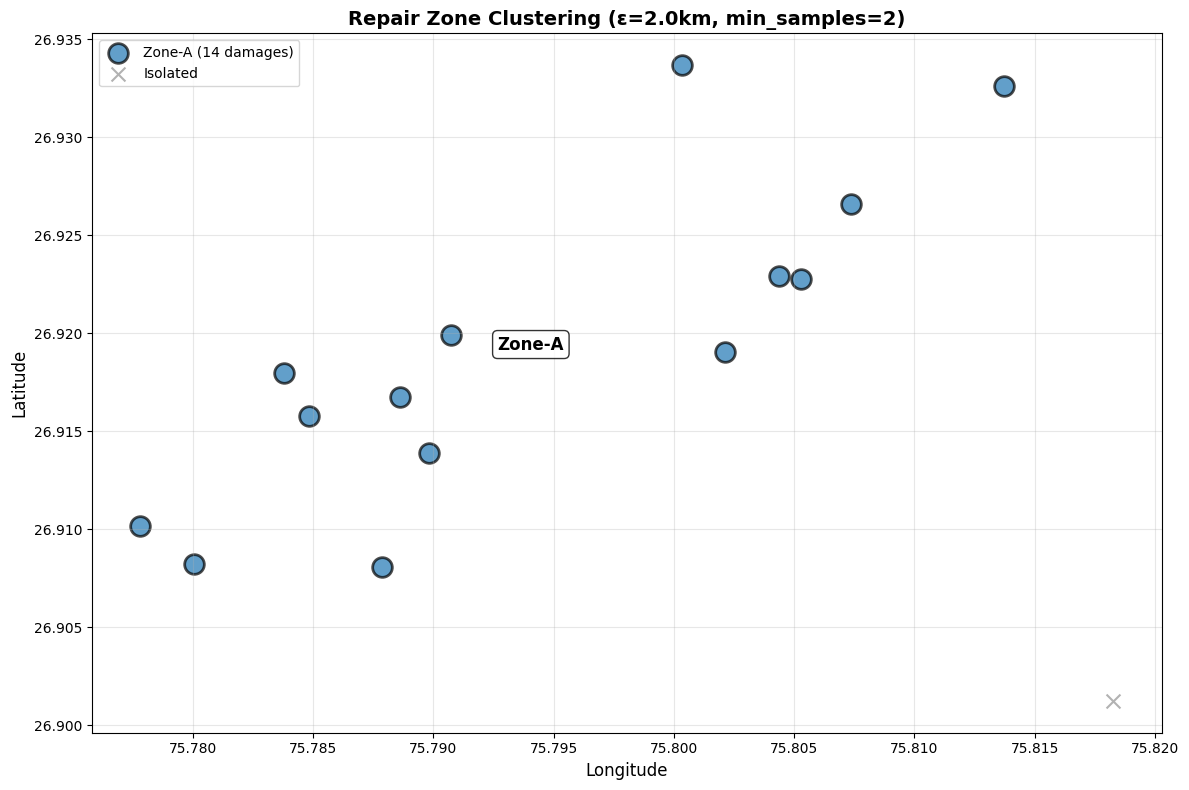

 Visualization complete: 2 zones identified


In [ ]:

# FEATURE 5: DBSCAN Clustering for Repair Zone Optimization

from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

class RepairZoneOptimizer:
    """
    Cluster damages into repair zones using DBSCAN
    to optimize crew deployment and reduce travel costs
    """

    def __init__(self, eps_km=0.5, min_samples=3):

        self.eps_km = eps_km
        self.min_samples = min_samples
        self.clusters = None

    def cluster_damages(self, detections_df):

        coords = detections_df[['latitude', 'longitude']].values

        eps_degrees = self.eps_km / 111.0

        # DBSCAN clustering
        clustering = DBSCAN(
            eps=eps_degrees,
            min_samples=self.min_samples,
            metric='euclidean'
        ).fit(coords)

        #  cluster labels to dataframe
        detections_df['cluster_id'] = clustering.labels_


        detections_df['zone_name'] = detections_df['cluster_id'].apply(
            lambda x: f"Zone-{chr(65+x)}" if x != -1 else "Isolated"
        )

        self.clusters = clustering

       # stats
        cluster_stats = self._calculate_cluster_stats(detections_df)

        return detections_df, cluster_stats

    def _calculate_cluster_stats(self, detections_df):
        """Calculate statistics for each cluster"""
        stats = []

        for cluster_id in detections_df['cluster_id'].unique():
            if cluster_id == -1:
                continue

            cluster_data = detections_df[detections_df['cluster_id'] == cluster_id]

            stats.append({
                'cluster_id': cluster_id,
                'zone_name': f"Zone-{chr(65+cluster_id)}",
                'num_damages': len(cluster_data),
                'total_cost': cluster_data['cost'].sum(),
                'avg_severity': cluster_data['severity'].mean(),
                'center_lat': cluster_data['latitude'].mean(),
                'center_lon': cluster_data['longitude'].mean(),
                'damage_types': cluster_data['damage_type'].value_counts().to_dict()
            })

        return pd.DataFrame(stats)

    def optimize_crew_deployment(self, cluster_stats_df, num_crews=3):

        sorted_zones = cluster_stats_df.sort_values('total_cost', ascending=False)

        # Assign crews
        assignments = []
        for i in range(min(num_crews, len(sorted_zones))):
            zone = sorted_zones.iloc[i]
            assignments.append({
                'crew_id': i + 1,
                'zone_name': zone['zone_name'],
                'num_repairs': zone['num_damages'],
                'total_cost': round(zone['total_cost'], 2),
                'center_location': (
                    round(zone['center_lat'], 6),
                    round(zone['center_lon'], 6)
                )
            })

        return {
            'crew_assignments': assignments,
            'total_crews_deployed': len(assignments),
            'zones_covered': len(assignments),
            'total_zones': len(cluster_stats_df)
        }

    def visualize_clusters(self, detections_df, figsize=(12, 8)):

        plt.figure(figsize=figsize)

        unique_clusters = detections_df['cluster_id'].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

        for i, cluster_id in enumerate(unique_clusters):
            cluster_data = detections_df[detections_df['cluster_id'] == cluster_id]

            if cluster_id == -1:

                plt.scatter(
                    cluster_data['longitude'],
                    cluster_data['latitude'],
                    c='gray',
                    marker='x',
                    s=100,
                    label='Isolated',
                    alpha=0.6
                )
            else:

                plt.scatter(
                    cluster_data['longitude'],
                    cluster_data['latitude'],
                    c=[colors[i]],
                    marker='o',
                    s=200,
                    label=f'Zone-{chr(65+cluster_id)} ({len(cluster_data)} damages)',
                    alpha=0.7,
                    edgecolors='black',
                    linewidth=2
                )

                center_lon = cluster_data['longitude'].mean()
                center_lat = cluster_data['latitude'].mean()
                plt.text(
                    center_lon, center_lat,
                    f'Zone-{chr(65+cluster_id)}',
                    fontsize=12,
                    fontweight='bold',
                    ha='center',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
                )

        plt.xlabel('Longitude', fontsize=12)
        plt.ylabel('Latitude', fontsize=12)
        plt.title(f'Repair Zone Clustering (ε={self.eps_km}km, min_samples={self.min_samples})',
                 fontsize=14, fontweight='bold')
        plt.legend(loc='best', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f" Visualization complete: {len(unique_clusters)} zones identified")

#  testing clustering
optimizer = RepairZoneOptimizer(eps_km=2.0, min_samples=2)

# sample seeding lets go
np.random.seed(42)

sample_detections = pd.DataFrame({
    'id': range(1, 16),
    'damage_type': np.random.choice(['pothole', 'crack'], 15),
    'severity': np.random.uniform(4, 9, 15),
    'cost': np.random.uniform(100, 500, 15),

    'latitude': np.concatenate([
        np.random.normal(26.912, 0.005, 6),   # Cluster A
        np.random.normal(26.925, 0.005, 5),   # Cluster B
        np.random.uniform(26.900, 26.940, 4)  # Isolated
    ]),
    'longitude': np.concatenate([
        np.random.normal(75.787, 0.005, 6),   # Cluster A
        np.random.normal(75.802, 0.005, 5),   # Cluster B
        np.random.uniform(75.770, 75.820, 4)  # Isolated
    ])
})


clustered_df, cluster_stats = optimizer.cluster_damages(sample_detections)

print("  Clustering Complete:")
print(f"\n Cluster Statistics:")
print(cluster_stats[['zone_name', 'num_damages', 'total_cost', 'avg_severity']])

crew_plan = optimizer.optimize_crew_deployment(cluster_stats, num_crews=2)

print(f"\n Crew Deployment Plan:")
for assignment in crew_plan['crew_assignments']:
    print(f"   Crew {assignment['crew_id']} → {assignment['zone_name']}")
    print(f"      Repairs: {assignment['num_repairs']}, Cost: ${assignment['total_cost']}")
    print(f"      Location: {assignment['center_location']}")
optimizer.visualize_clusters(clustered_df)

In [ ]:

# PIPELINE: Detection to Assessment to Prioritization (phu)


from ultralytics import YOLO
import cv2

class PaveScanPipeline:


    def __init__(self, model_path='runs/detect/road_damage_model/weights/best.pt'):
        self.model = YOLO(model_path)
        self.severity_scorer = SeverityScorer()
        self.cost_estimator = CostEstimator()
        self.gps_tagger = GPSTagger()
        self.prioritizer = MaintenancePrioritizer()
        self.optimizer = RepairZoneOptimizer(eps_km=0.5, min_samples=2)

    def process_image(self, image_path, latitude, longitude,
                     traffic_volume='medium', weather_risk='low'):


        results = self.model.predict(image_path, conf=0.25, verbose=False)[0]

        detections = []
        for box in results.boxes:

            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            damage_type = self.model.names[cls]

            bbox_area = (x2 - x1) * (y2 - y1)
            image_area = 640 * 640

            severity = self.severity_scorer.calculate_severity(
                damage_type, bbox_area, conf, image_area
            )

            cost_data = self.cost_estimator.estimate_cost(
                damage_type, bbox_area
            )
            detection = self.gps_tagger.add_detection(
                damage_type=damage_type,
                bbox={'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2},
                confidence=conf,
                severity=severity,
                cost=cost_data['total_cost'],
                latitude=latitude,
                longitude=longitude
            )

            detections.append(detection)

        return {
            'image': image_path,
            'detections': detections,
            'total_damages': len(detections),
            'total_cost': sum(d['cost'] for d in detections)
        }


pipeline = PaveScanPipeline()


result = pipeline.process_image(
    image_path='yolo_dataset/valid/images/valid_0.jpg',
    latitude=26.9124,
    longitude=75.7873,
    traffic_volume='high',
    weather_risk='medium'
)


print(" PAVESCAN complete PIPELINE TEST")

print(f"\n Image: {result['image']}")
print(f"Detections: {result['total_damages']}")
print(f" Total Cost: ${result['total_cost']:.2f}")

print("\n Detection Details:")
for det in result['detections']:
    print(f"\n  {det['damage_type'].upper()}:")
    print(f"    Confidence: {det['confidence']:.2f}")
    print(f"    Severity: {det['severity']}/10")
    print(f"    Cost: ${det['cost']:.2f}")
    print(f"    GPS: ({det['location']['latitude']}, {det['location']['longitude']})")


print(" ML MODEL DONE YAYAY!")


 PAVESCAN complete PIPELINE TEST

 Image: yolo_dataset/valid/images/valid_0.jpg
Detections: 3
 Total Cost: $8042.70

 Detection Details:

  POTHOLE:
    Confidence: 0.51
    Severity: 5.67/10
    Cost: $2679.60
    GPS: (26.9124, 75.7873)

  POTHOLE:
    Confidence: 0.39
    Severity: 5.22/10
    Cost: $2579.19
    GPS: (26.9124, 75.7873)

  POTHOLE:
    Confidence: 0.28
    Severity: 4.8/10
    Cost: $2783.91
    GPS: (26.9124, 75.7873)
 ML MODEL DONE YAYAY!
